In [2]:
!pip install -q tensorflow gradio

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, zipfile, os
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image

In [4]:
from google.colab import files
uploaded = files.upload()

Saving E waste data.zip to E waste data.zip


In [10]:
import zipfile
import os

with zipfile.ZipFile('E waste data.zip', 'r') as zip_ref:
    zip_ref.extractall('E waste data')

In [11]:
trainpath = 'E waste data/modified-dataset/train'
testpath = 'E waste data/modified-dataset/test'
validpath = 'E waste data/modified-dataset/val'

In [13]:
IMG_SIZE  = 260          # EfficientNetV2-B2 native
BATCH     = 32
NUM_CLASS = 10
def make_ds(path, shuffle):
    return keras.utils.image_dataset_from_directory(
        path,
        shuffle=shuffle,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH
    )

ds_train = make_ds(trainpath,  True)
ds_val   = make_ds(validpath,  True)
ds_test  = make_ds(testpath,   False)

class_names = ds_train.class_names

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [14]:
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="simple_aug")

In [17]:
base = EfficientNetV2B2(include_top=False, weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = True       # fine-tune
for layer in base.layers[:100]:
    layer.trainable = False

inputs   = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = augment(inputs)
x = preprocess_input(x)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)                    # was 0.2
outputs = layers.Dense(NUM_CLASS, activation='softmax')(x)
model   = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary(); base.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_aug (Sequential)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        14,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,783,464 (33.51 MB)

 Trainable params: 7,980,278 (30.44 MB)

 Non-trainable params: 803,186 (3.06 MB)

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 260, 260,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 260, 260,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [18]:
early = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(ds_train, validation_data=ds_val,
                    epochs=15, callbacks=[early])

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 864s 11s/step - accuracy: 0.3727 - loss: 1.9709 - val_accuracy: 0.9267 - val_loss: 0.6855
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 858s 11s/step - accuracy: 0.8836 - loss: 0.5934 - val_accuracy: 0.9733 - val_loss: 0.1972
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 795s 11s/step - accuracy: 0.9350 - loss: 0.2362 - val_accuracy: 0.9700 - val_loss: 0.1262
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 792s 10s/step - accuracy: 0.9505 - loss: 0.1679 - val_accuracy: 0.9800 - val_loss: 0.0827
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 787s 10s/step - accuracy: 0.9761 - loss: 0.0985 - val_accuracy: 0.9733 - val_loss: 0.0773
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 802s 10s/step - accuracy: 0.9741 - loss: 0.0950 - val_accuracy: 0.9767 - val_loss: 0.0747
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 795s 10s/step - accuracy: 0.9822 - loss: 0.0656 - val_accuracy: 0.9733 - val_loss: 0.0669
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 812s 11s/step - accuracy: 0.9847 - loss: 0.0587 - val_accuracy: 0.

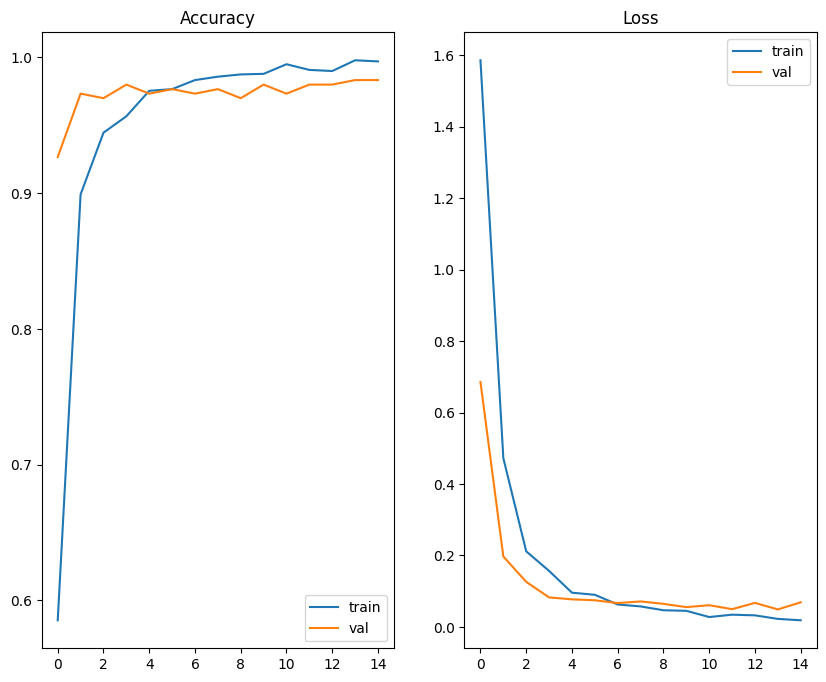

In [19]:
acc  = history.history['accuracy'];  val_acc  = history.history['val_accuracy']
loss = history.history['loss'];      val_loss = history.history['val_loss']
rng  = range(len(acc))

plt.figure(figsize=(10,8))
plt.subplot(1,2,1); plt.plot(rng, acc, label='train'); plt.plot(rng, val_acc, label='val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2); plt.plot(rng, loss, label='train'); plt.plot(rng, val_loss, label='val')
plt.title('Loss'); plt.legend(); plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9827 - loss: 0.0702
Test accuracy 0.9833 | loss 0.0802
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  0  1]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  1  0  0  1  0 28  0  0]
 [ 0  0  1  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
                 precision    recall  f1-score   support

        Battery       1.00      0.97      0.98        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.94      0.97      0.95        30
         Mobile       1.00      1.00      1.00        30
          Mouse       1.00      1.00      1.00        30
            PCB       0.94      1.00      0.97        30
         Player       1.00      1.00      1.00        30
        Printer       1.00      0.93      0.97        30
     Tel

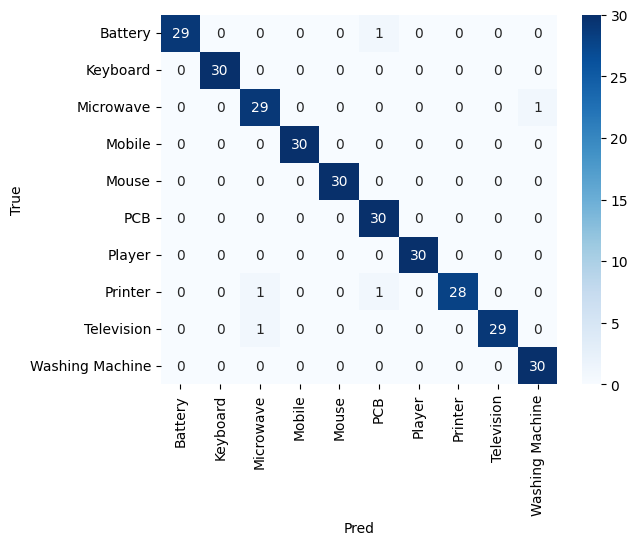

In [20]:
loss, acc = model.evaluate(ds_test)
print(f"Test accuracy {acc:.4f} | loss {loss:.4f}")

y_true = np.concatenate([y.numpy() for _, y in ds_test])
y_pred = np.argmax(model.predict(ds_test), axis=1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

In [21]:
def classify_image(img):
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = preprocess_input(np.array(img, dtype=np.float32))
    prob = model.predict(arr[np.newaxis, ...])
    idx  = int(prob.argmax())
    return f"{class_names[idx]}  ({prob[0][idx]:.2f})"

iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs="text",
                     title="E-Waste Classifier – EfficientNetV2-B2")
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://83a6fcb1fb9993a6c1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
